In [1]:
import os
os.chdir('/home/syamil/masters')

import logging

logger = logging.getLogger('bayesian_nn')

In [2]:
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
from emcee.moves import GaussianMove
import matplotlib.pylab as pylab
from time import time
import itertools

from bayesian import generate_data_v2
from src.utils.transforms import normalise_bands
from src.inference.sampler import BayesSampler, default_model
from src.inference.estimate import get_samples, get_sample_uncorrelated
from src.inference.evaluate import kl_divergence, get_psrf, coefficient_of_variance, get_prediction_interval
from src.inference.plots import plot_psrf, plot_trace, plot_auto_corr, plot_confidence_ellipse, plot_results
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# use Latex for the labels in plots
# plt.rcParams['text.usetex'] = True
# plt.rcParams.update({'font.size': 22})
# plt.style.use('science')
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (8,6),   
    "font.size": 18,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
num_obs = 10
num_experiment = 1
length_scale = 1e3
material_params = {
    "G": 30000 / length_scale,
    "K": 30000 / length_scale,
    "length_scale": length_scale
}
data = generate_data_v2(num_obs=num_obs, num_experiments=num_experiment, **material_params)

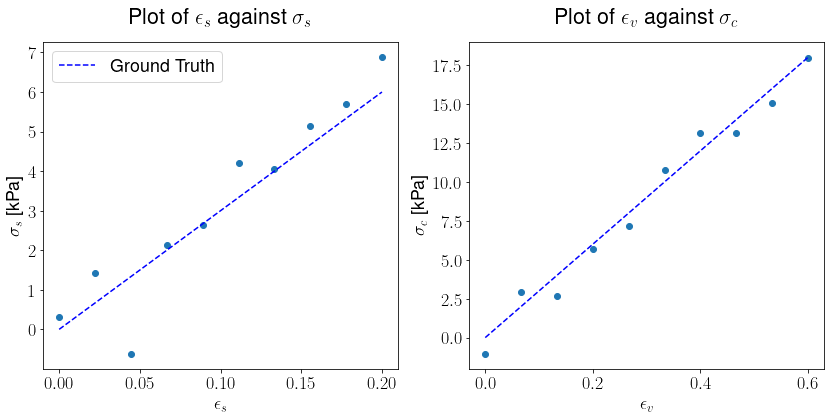

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
axes[0].scatter(data[0][:,0], data[2][:,0])
axes[0].plot(data[0][:,0], data[1][:,0], 'b--', label='Ground Truth')
axes[0].set_title(r'Plot of $\epsilon_s$ against $\sigma_s$', pad=20)
axes[0].set_xlabel(r'$\epsilon_s$')
axes[0].set_ylabel(r'$\sigma_s$ [kPa]')
axes[0].legend()
    

axes[1].scatter(data[0][:,1], data[2][:,1])
axes[1].plot(data[0][:,1], data[1][:,1], 'b--', label='Ground Truth')
axes[1].set_title(r'Plot of $\epsilon_v$ against $\sigma_c$', pad=20)
axes[1].set_xlabel(r'$\epsilon_v$')
axes[1].set_ylabel(r'$\sigma_c$ [kPa]')
axes[0].legend()

# plt.savefig('assets/synthetic_data.svg')
plt.show()

In [5]:
priors = dict(G=stats.norm(loc=30, scale=10), K=stats.norm(loc=30, scale=10), noise=1)
sampler = BayesSampler(priors)

In [6]:
x, _, y_noise  = data
mle = sampler.max_likelihood(x, y_noise)
print(mle)

(array([32.53997097, 29.49959467]), array([1.96439127, 0.77468441]))


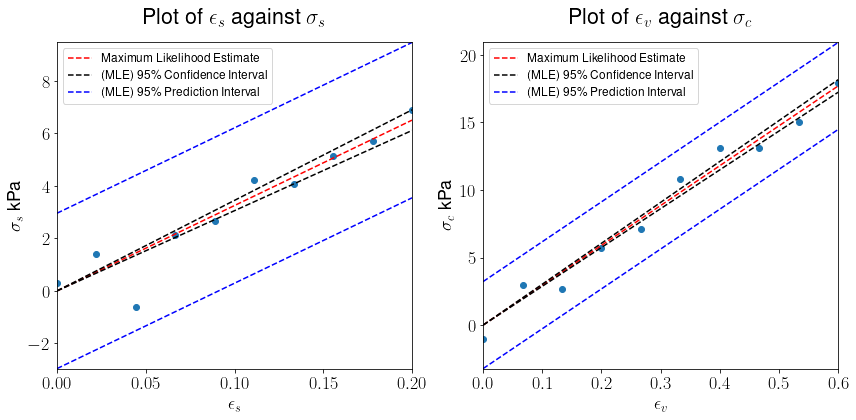

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
lower, upper = get_prediction_interval(x, y_noise, mle[0], model=default_model)
mle_output = default_model(mle[0], x)
error_g, error_k = mle[1]
axes[0].scatter(x.T[0], y_noise.T[0])
axes[0].plot(x.T[0], mle_output.T[0], 'r--', label='Maximum Likelihood Estimate')
axes[0].plot(x.T[0], x.T[0] * (mle[0][0] - error_g), 'k--', label="(MLE) 95\% Confidence Interval")
axes[0].plot(x.T[0], x.T[0] * (mle[0][0] + error_g), 'k--')
axes[0].plot(x.T[0],  lower[0], 'b--', label='(MLE) 95\% Prediction Interval')
axes[0].plot(x.T[0],  upper[0], 'b--')
axes[0].set_title(r'Plot of $\epsilon_s$ against $\sigma_s$', pad=20)
axes[0].set_xlabel(r'$\epsilon_s$')
axes[0].set_ylabel(r'$\sigma_s$ kPa')
axes[0].legend(fontsize=12)  
# axes[0].set_ylim(0, 12.5)
axes[0].autoscale(tight=True)

    
axes[1].scatter(x.T[1], y_noise.T[1]) 
axes[1].plot(x.T[1], mle_output.T[1], 'r--', label='Maximum Likelihood Estimate')
axes[1].plot(x.T[1], x.T[1] * (mle[0][1] + error_k), 'k--', label="(MLE) 95\% Confidence Interval")
axes[1].plot(x.T[1], x.T[1] * (mle[0][1] - error_k), 'k--')
axes[1].plot(x.T[1],  lower[1], 'b--', label='(MLE) 95\% Prediction Interval')
axes[1].plot(x.T[1],  upper[1], 'b--')
axes[1].set_title(r'Plot of $\epsilon_v$ against $\sigma_c$', pad=20)
axes[1].set_xlabel(r'$\epsilon_v$')
axes[1].set_ylabel(r'$\sigma_c$ kPa')
axes[1].legend(fontsize=12)    
# axes[1].set_ylim(0, 32)
axes[1].autoscale(tight=True)
# plt.savefig('assets/mle.svg')

# M-H MCMC Sampling

In [8]:
num_walkers = 5
num_chains=1_00_00
proposal_dist = GaussianMove(cov=np.array([20,10]))

sampler.fit(x, y_noise, num_walkers=num_walkers, num_chains=num_chains, moves=proposal_dist)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 632.29it/s]
2022-08-15 15:18:32,332 - bayesian_nn - INFO - Sampling took 15.8 seconds


## Get Sampler Acceptance fraction

In [9]:
sampler.acceptance_fraction

[0.2087 0.2084 0.2135 0.2073 0.2097]


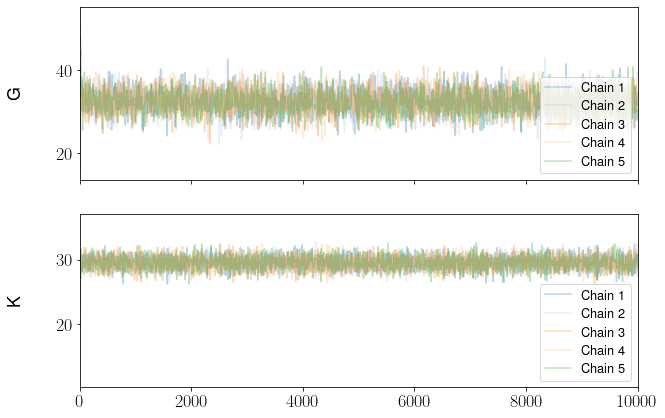

In [10]:
plot_trace(sampler, show_chains=True)
# plt.savefig('assets/trace_plot.svg', bbox_inches='tight')

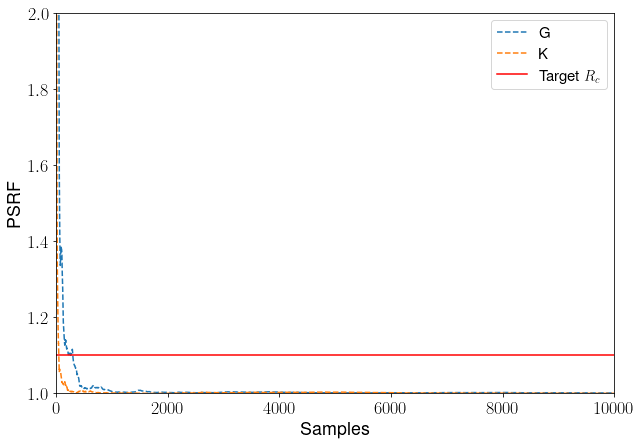

In [11]:
# # plt.savefig('assets/psrf_plot.svg', bbox_inches='tight')
plot_psrf(sampler)

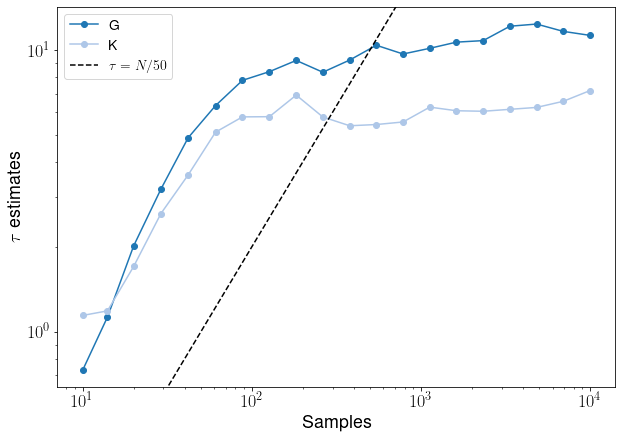

In [12]:
plot_auto_corr(sampler)
# plt.savefig('assets/autocorr_1.svg',  bbox_inches='tight')

In [13]:
lims = np.array([[0.01, 200.0],
                     [0.01, 200.0]])

# load and plot the samples from emcee?
check_samples = True



model = default_model
# assert lims.shape == (model.nparams, 2),'lims.shape != (model.nparams, 2)'
ngrid = 300

# define the "grid" of parameter values on which to sample (grid.shape = (ngrid, nparams))
grid = np.array([np.linspace(lims[i,0],lims[i,1],ngrid) for i in range(sampler.n_params)]).T
dval = np.array([grid[1,i]-grid[0,i] for i in range(sampler.n_params)]) 

# prior for all parameter values (lprior.shape = (ngrid, nparams))
lprior = np.array([sampler.prior(grid[i,:]) for i in range(ngrid)])

# print the maximum value of the posterior
for i in range(sampler.n_params):
    print('max prior',sampler.param_names[i],'=',grid[:,i][np.argmax(lprior[:,i])])

# likelihood for all parameter values
llhood = np.array([sampler.log_likelihood(np.array(i),x,y_noise)
    for i in itertools.product(*grid.T)]).reshape([ngrid for j in range(sampler.n_params)])
llhood = np.exp(llhood)

# calculate and print the maximum likelihood estimate
iimax = np.unravel_index(llhood.argmax(),llhood.shape) 
MLE = np.array([grid[:,i][iimax[i]] for i in range(sampler.n_params)])
for i in range(sampler.n_params):
    print('MLE',sampler.param_names[i],'=',MLE[i])

# posterior for all parameters values
lposterior = np.array([v*np.product([lprior[i[j],j] for j in range(sampler.n_params)])
  for i,v in np.ndenumerate(llhood)]).reshape([ngrid for j in range(sampler.n_params)])

# integrate over all parameters and normalize the posterior
normC = np.sum(dval.prod()*lposterior)
lposterior = lposterior/normC

# calculate and print the maximum a-posterior
iimax = np.unravel_index(lposterior.argmax(),lposterior.shape) 
MAP = np.array([grid[:,i][iimax[i]] for i in range(sampler.n_params)])
for i in range(sampler.n_params):
    print('MAP',sampler.param_names[i],'=',MAP[i])

# calculate marginalized posteriors and likelihoods
marg = np.zeros(grid.shape)
margl = np.zeros(grid.shape)
for i in range(sampler.n_params):
    inds = [j for j in range(sampler.n_params) if j != i ]
    marg[:,i] = np.sum(np.prod(dval[inds])*lposterior,axis=tuple(inds))
    margl[:,i] = np.sum(np.prod(dval[inds])*llhood,axis=tuple(inds))


max prior G = 30.108829431438128
max prior K = 30.108829431438128
MLE G = 32.78428093645485
MLE K = 29.439966555183947
MAP G = 32.11541806020067
MAP K = 29.439966555183947


(0.0, 60.0)

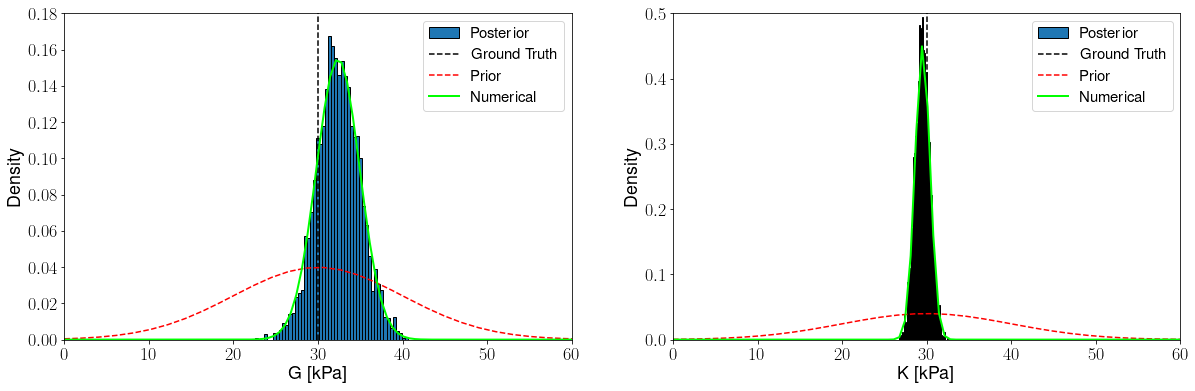

In [14]:
flat_samples = sampler.get_chain(flat=True, thin=14, discard=105)
fig, [ax_g, ax_k] = plt.subplots(ncols=2, nrows=1, figsize=(20,6))
nsamples, ndim = flat_samples.shape

ax_g.hist(flat_samples[:,0], bins=50, density=True, label="Posterior", histtype='bar',ec='black')
# ax_g.set_title("Histogram of G Samples")
ax_g.title.set_size(24)
ax_g.set_xlabel(r'G [kPa]')
ax_g.set_ylabel(r'Density')
ax_g.axvline(material_params["G"], ls="--", color="k", label='Ground Truth')

ax_k.hist(flat_samples[:,1], bins=50, density=True, label='Posterior', ec='black')
# ax_k.set_title("Histogram of K Samples")
ax_k.title.set_size(24)
ax_k.set_xlabel(r'K [kPa]')
ax_k.set_ylabel(r'Density')
ax_k.axvline(material_params["K"], ls="--", color="k", label='Ground Truth')



bins = 20
for i, dist in enumerate(sampler.param_dist):
    if i !=2 :
        ax = fig.axes[i]
        params = np.linspace(0, 100)
        params_space = params[1] - params[0]
        space_prob = dist.cdf(params + 0.5 * params_space) - dist.cdf(params - 0.5 * params_space)
        probs = nsamples * (1 / bins) * space_prob
        ax.plot(params, dist.pdf(params), 'r--', label='Prior')
        
ax_g.plot(grid[:,0],marg[:,0],label='Numerical',color='lime', lw=2.0)
ax_k.plot(grid[:,1],marg[:,1],label='Numerical',color='lime', lw=2.0)
# ax_g>.plot(g_vec,post_g,label='Numerical',color='green', lw=2.0)  
# ax_k.plot(g_vec,post_k,label='Numerical',color='green', lw=2.0)  

ax_g.legend(fontsize=15)    
ax_g.autoscale(tight=True)
ax_g.set_ylim(0, 0.18)
ax_g.set_xlim(0, 60)

ax_k.legend(fontsize=15)    
ax_k.autoscale(tight=True)
ax_k.set_ylim(0, 0.5)
ax_k.set_xlim(0, 60)
# plt.savefig('assets/posterior.svg', bbox_inches='tight')

In [15]:
mle_output = model(mle[0], x)
error_g, error_k = mle[1]
err_cov = 1.96 * np.array([[error_g**2, 0],[0, error_k**2]])


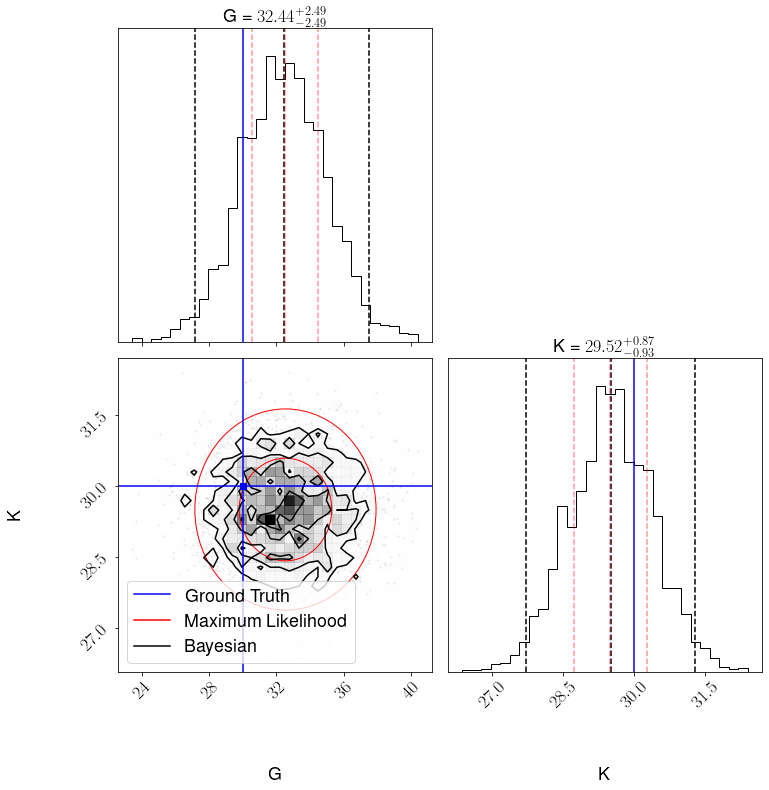

In [18]:
truths=list(material_params.values())[:2]
fig = plt.figure(figsize=(12,12))
flat_samples = sampler.get_chain(flat=True, thin=17, discard=250)
flat_samples = flat_samples[:, :2]
bins = 30

nsamples, ndims = flat_samples.shape

fig = corner.corner(flat_samples, bins=bins, labels=sampler.param_names[:2],
                    quantiles=[0.02, 0.5, 0.977],
                    show_titles=True, title_kwargs={"fontsize": 18}, scale_hist=False, fig=fig)

# Extract the axes
axes = np.array(fig.axes).reshape((ndims, ndims))

mle_vals = np.array([mle[0] -  mle[1], mle[0], mle[0] + mle[1]])

# Loop over the diagonal
for i in range(ndims):
    ax = axes[i, i]
    ax.axvline(truths[i], color="blue")
    [ax.axvline(mle_vals[n,i], color='red', ls='--', alpha=0.4) for n in range(3)]

    
# Loop over the histograms
for yi in range(ndims):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline
        ax.axvline(truths[xi], color="blue")
        ax.axhline(truths[yi], color="blue")
        ax.plot(truths[xi], truths[yi], "sb")
        plot_confidence_ellipse(mle[0], err_cov, ax, n_std=1)
        plot_confidence_ellipse(mle[0], err_cov, ax, n_std=1.96)
        ax.legend([plt.plot([],ls="-", color='blue')[0] , plt.plot([],ls="-", color='r')[0], plt.plot([],ls="-", color='k')[0]], ['Ground Truth', 'Maximum Likelihood', 'Bayesian'],loc='lower left')
        

# plt.savefig('assets/corner_1.svg',  bbox_inches='tight')

2022-08-15 15:18:47,424 - bayesian_nn - INFO - auto-correlation (G): 11.257570617888234
2022-08-15 15:18:47,425 - bayesian_nn - INFO - auto-correlation (K): 7.170122506703597
2022-08-15 15:18:51,614 - bayesian_nn - INFO - PSRF at end of chain: [1.00084406 0.99990672]
2022-08-15 15:18:51,615 - bayesian_nn - INFO - Burn-in: 261
2022-08-15 15:18:51,616 - bayesian_nn - INFO - Thin: 11
2022-08-15 15:18:51,617 - bayesian_nn - INFO - Flat chain shape: (4425, 2)
2022-08-15 15:18:51,618 - bayesian_nn - INFO - Log prob shape: (4425,)
2022-08-15 15:18:51,620 - bayesian_nn - INFO - Log prior shape: (4425,)
2022-08-15 15:18:51,621 - bayesian_nn - INFO - Log likelihood shape: (4425,)


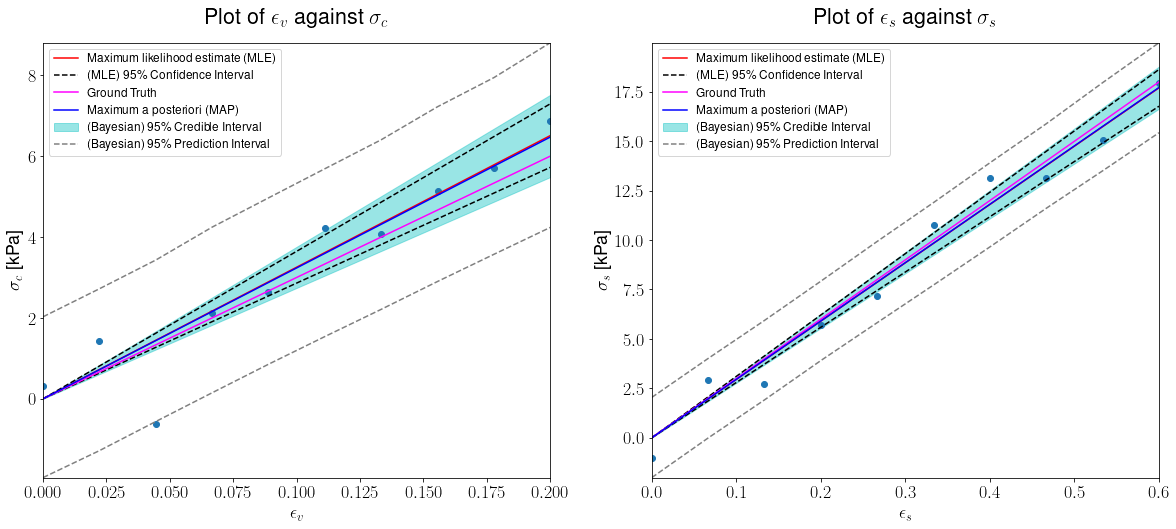

In [19]:
plot_results(x, y_noise, sampler,  list(material_params.values())[:2])

# plt.savefig('assets/overall_1.svg',  bbox_inches='tight')